>## Работа по курсу "Программирование на Python" на тему 
>### *"Распознавании рукописных цифр на изображении"*
>#### Выполнили: 
> Макин Евгений, Рооп Михаил и Темнова Мария

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 1. Подготовка данных
## 1.1. Загрузка данных (MNIST)

In [49]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

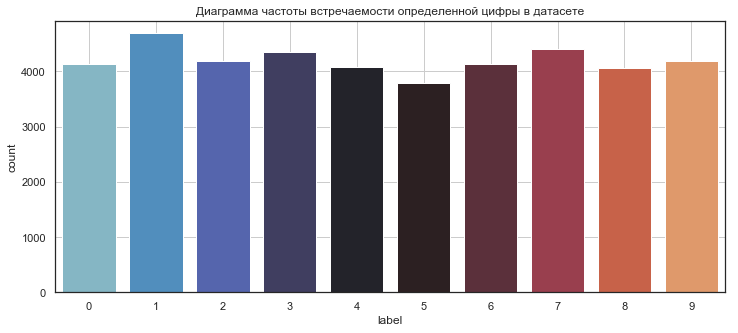

In [52]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

plt.figure(figsize=(12,5))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Диаграмма частоты встречаемости определенной цифры в датасете")
plt.grid()
count_label = pd.DataFrame({'label':Y_train.value_counts().index, 'count':Y_train.value_counts().values})


In [55]:
# DataFrame, содержащий информацию о частоте встречаемости определенной цифры в датасете
count_label.T

,0,1,2,3,4,5,6,7,8,9
label,1,7,3,9,2,6,0,4,8,5
count,4684,4401,4351,4188,4177,4137,4132,4072,4063,3795


>В итоге мы видим, что количество изображений каждой цифры в датасете пости одинаковое

In [5]:
del train

## 2.1. Проверка на пропуски в данных

In [6]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

>Пропущенных значений в данных нет

## 3.1. Нормализация данных

>Выполним Grayscale normalization (перейдем от описания цвета [0..255] к [0..1]) 

In [56]:
X_train = X_train / 255.0
test = test / 255.0

## 4.1. Изменение размерности данных

In [57]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

>Тренировочные и тестовые изображения представляют собой 1D вектора из 784 значений. Мы преобразуем эти данные к 3D матрице 28x28x1. Keras требует, чтобы в конце мы добавляли дополнительное измерение, которое соответсвует количеству каналов. Изображения из наших данных в оттенках серого, поэтому используется только один канал. Отметим, что если бы мы имели разноцветные изображения (RGB - 3 канала), мы бы преобразовали векторы 784px в трехмерные матрицы 28x28x3

## 5.1. Кодирование ответов (Label encoding)

In [58]:
# Например:
# цифра 8 -> [0,0,0,0,0,0,0,0,1,0])
# цифра 4 -> [0,0,0,0,1,0,0,0,0,0])

Y_train = to_categorical(Y_train, num_classes = 10)

## 6.1. Разделение на тренировочный и валидационный датасет


In [59]:
# чтобы восстановить потом наше разделение
random_seed = 2

In [60]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Мы решили разделить наше данные на две части: первая небольшая часть (10%) для валидации, по ней мы будем оценивать качество модели, вторая часть (90%) используется для обучения модели.

## 7.1. Визуализация данных

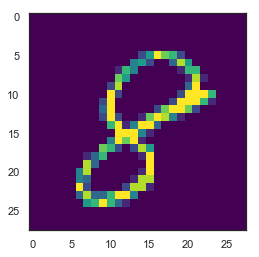

In [14]:
g = plt.imshow(X_train[0][:,:,0], cmap=plt.cm.viridis)

# 2. CNN
## 2.1 Создание модели

#### CNN architechture:

$In -> [[Conv2D->RELU]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out$

In [61]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

#### Типовая архитектура свёрточной нейронной сети
![title](photo/CNN.png)
![title](photo/Typical_cnn.png)

>В обычном перцептроне, который представляет собой полносвязную нейронную сеть, каждый нейрон связан со всеми нейронами предыдущего слоя, причём каждая связь имеет свой персональный весовой коэффициент. В свёрточной нейронной сети в операции свёртки используется лишь ограниченная матрица весов небольшого размера, которую «двигают» по всему обрабатываемому слою (в самом начале — непосредственно по входному изображению), формируя после каждого сдвига сигнал активации для нейрона следующего слоя с аналогичной позицией. То есть для различных нейронов выходного слоя используются одна и та же матрица весов, которую также называют ядром свёртки. Её интерпретируют как графическое кодирование какого-либо признака, например, наличие наклонной линии под определённым углом. Тогда следующий слой, получившийся в результате операции свёртки такой матрицей весов, показывает наличие данного признака в обрабатываемом слое и её координаты, формируя так называемую карту признаков (англ. **feature map**). Естественно, в свёрточной нейронной сети набор весов не один, а целая гамма, кодирующая элементы изображения (например линии и дуги под разными углами). При этом такие ядра свёртки не закладываются исследователем заранее, а формируются самостоятельно путём обучения сети классическим методом обратного распространения ошибки. Проход каждым набором весов формирует свой собственный экземпляр карты признаков, делая нейронную сеть многоканальной (много независимых карт признаков на одном слое). Также следует отметить, что при переборе слоя матрицей весов её передвигают обычно не на полный шаг (размер этой матрицы), а на небольшое расстояние. Так, например, при размерности матрицы весов 5×5 её сдвигают на один или два нейрона (пикселя) вместо пяти, чтобы не «перешагнуть» искомый признак.

>Операция субдискретизации (англ. **subsampling**, англ. **pooling**, также переводимая как «операция подвыборки» или операция объединения), выполняет уменьшение размерности сформированных карт признаков. В данной архитектуре сети считается, что информация о факте наличия искомого признака важнее точного знания его координат, поэтому из нескольких соседних нейронов карты признаков выбирается максимальный и принимается за один нейрон уплотнённой карты признаков меньшей размерности. За счёт данной операции, помимо ускорения дальнейших вычислений, сеть становится более инвариантной к масштабу входного изображения.

>Рассмотрим типовую структуру свёрточной нейронной сети более подробно. Сеть состоит из большого количества слоёв. После начального слоя (входного изображения) сигнал проходит серию свёрточных слоёв, в которых чередуется собственно свёртка и субдискретизация (пулинг). Чередование слоёв позволяет составлять «карты признаков» из карт признаков, на каждом следующем слое карта уменьшается в размере, но увеличивается количество каналов. На практике это означает способность распознавания сложных иерархий признаков. Обычно после прохождения нескольких слоёв карта признаков вырождается в вектор или даже скаляр, но таких карт признаков становятся сотни. На выходе свёрточных слоёв сети дополнительно устанавливают несколько слоёв полносвязной нейронной сети (перцептрон), на вход которому подаются оконечные карты признаков.



#### Свертка (Convolution Operation)
![title](photo/gec.jpg)
![title](photo/keras_conv2d_padding.gif)

#### ReLU
>После создания слоя свертки мы используем ReLU, чтобы увеличить нелинейность

![title](photo/RELU.jpg)

#### Операция субдискретизации (Pooling)
![title](photo/CNN_3.png)

#### Dropout

>Переобучение (overfitting) — одна из проблем глубоких нейронных сетей (Deep Neural Networks, DNN), состоящая в следующем: модель хорошо объясняет только примеры из обучающей выборки, адаптируясь к обучающим примерам, вместо того чтобы учиться классифицировать примеры, не участвовавшие в обучении (теряя способность к обобщению). За последние годы было предложено множество решений проблемы переобучения, но одно из них превзошло все остальные, благодаря своей простоте и прекрасным практическим результатам; это решение — Dropout (в русскоязычных источниках — “метод прореживания”, “метод исключения” или просто “дропаут”).

>Суть метода заключается в том, что в процессе обучения выбирается слой, из которого случайным образом выбрасывается определённое количество нейронов (например 30%), которые выключаются из дальнейших вычислений.Такой приём улучшает эффективность обучения и качество результата. Более обученные нейроны получают в сети больший вес.

![title](photo/dropout.jpg)

#### Flattening
>Этот слой используется для преобразования окончательных карт объектов в один одномерный вектор.  Он сочетает в себе все найденные локальные особенности предыдущих сверточных слоев.

![title](photo/flattenigng.jpg)


## 3.2. Оптимизация 
После того, как наши слои добавлены в модель, нам нужно настроить функцию оценки, функцию потерь и алгоритм оптимизации.
Мы определяем функцию потерь, чтобы измерить, насколько плохо наша модель работает на изображениях с известными метками. Это частота ошибок между надписанными метками и предсказанными. Мы используем специальную форму для категориальных классификаций (> 2 классов), называемую "categorical_crossentropy".
![title](photo/cce.jpg)

В качестве оптимизатора выберем RMSprop, который работает быстрее чем  Stochastic Gradient Descent ('sgd')

In [65]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [64]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

>Чтобы оптимизатор сходился быстрее и ближе к глобальному минимуму функции потерь, мы используем метод отжига (annealing method) скорости обучения.

In [62]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [63]:
epochs = 5
batch_size = 86

## 3.3. Увеличение числа данных (Data augmentation)

>Чтобы избежать проблемы переобучения, нам нужно искусственно расширить наш набор рукописных цифр. Мы можем сделать существующий набор данных еще больше. Идея состоит в том, чтобы изменить тренировочные данные небольшими преобразованиями, чтобы воспроизвести изменения, возникающие, когда кто-то пишет цифру.
Например, число не центрировано. Масштаб не одинаков (некоторые пишут большими / маленькими цифрами). Повороты изображений.
Подходы, которые изменяют обучающие данные способами, которые изменяют представление массива, сохраняя метку одинаковой, известны как методы дополнения данных.
Применяя только пару этих преобразований к нашим данным обучения, мы можем легко удвоить или утроить количество примеров обучения и создать очень надежную модель.

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [66]:
# model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

## 3.4. Обучение модели

In [67]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
 - 230s - loss: 0.4254 - acc: 0.8631 - val_loss: 0.0628 - val_acc: 0.9776
Epoch 2/5
 - 231s - loss: 0.1313 - acc: 0.9610 - val_loss: 0.0481 - val_acc: 0.9869
Epoch 3/5
 - 238s - loss: 0.0948 - acc: 0.9726 - val_loss: 0.0351 - val_acc: 0.9890
Epoch 4/5
 - 236s - loss: 0.0842 - acc: 0.9756 - val_loss: 0.0348 - val_acc: 0.9902
Epoch 5/5
 - 261s - loss: 0.0747 - acc: 0.9789 - val_loss: 0.0322 - val_acc: 0.9905


# 4. Оценка модели
## 4.1. Тренировочная и валидационная кривая

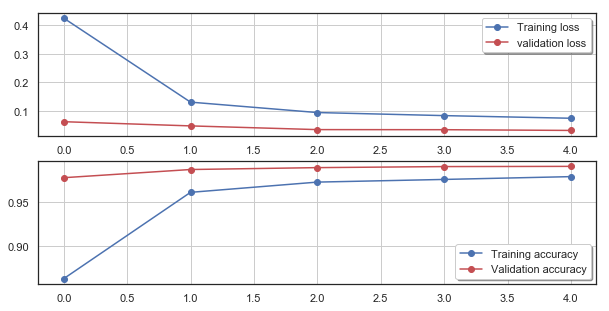

In [83]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(history.history['loss'], marker='o', color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], marker='o', color='r', label="validation loss",axes =ax[0])
ax[0].grid()
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], marker='o', color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], marker='o', color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
ax[1].grid()

> Наши кривые показывают, что наша модель очень хорошо обучена

## 4.2. Матрица согласованности предсказанных и реальных меток (Confusion matrix)

>Эта матрица может быть очень полезна, чтобы увидеть недостатки вашей модели.

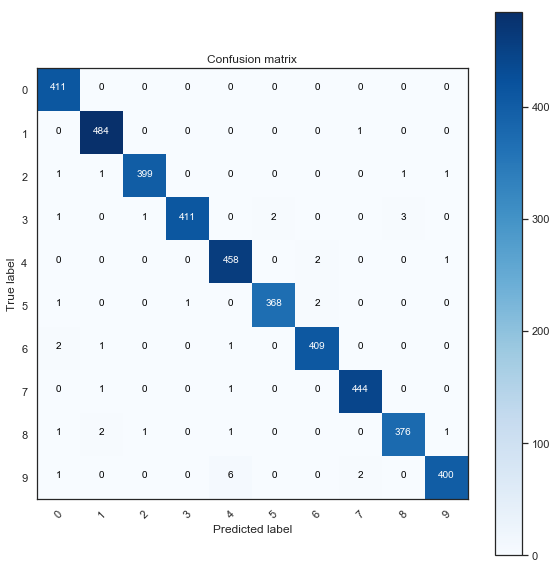

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

>Мы видим, что наш CNN очень хорошо работает на всех цифрах и мы допускаем небольшое количество ошибок. Но также отметим, что мы ошибаемся с классификацией цифры 4 ( мы часто путаем ее с 9)

## 4.3. Исследование ошибок

> Проанализируем самые важные ошибки

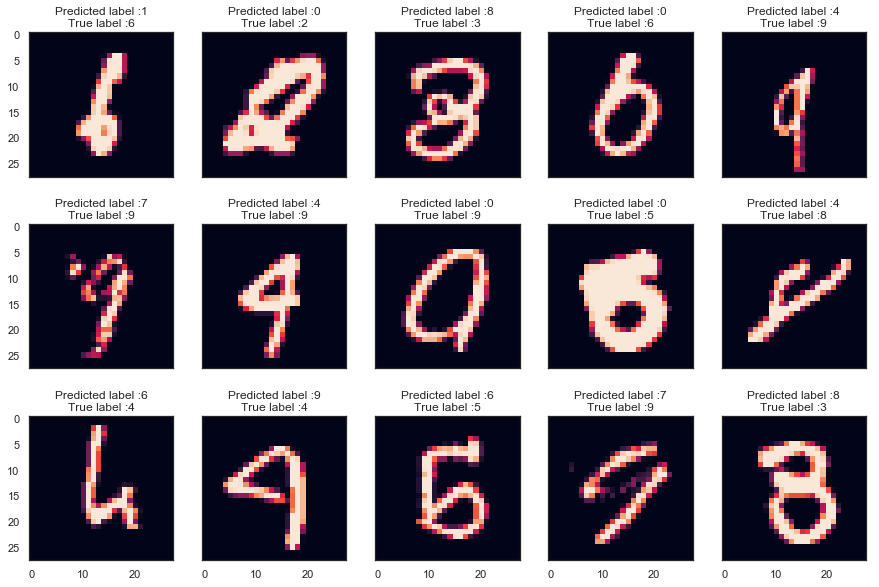

In [85]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(15,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
# Вероятности неправильных предсказанных чисел
Y_pred_errors_prob = np.max (Y_pred_errors, axis = 1)

# Предсказанные вероятности истинных значений в наборе ошибок
true_prob_errors = np.diagonal (np.take (Y_pred_errors, Y_true_errors, axis = 1))

# Разница между вероятностью предсказанной метки и истинной меткой
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Сортированный список ошибок
sorted_dela_errors = np.argsort (delta_pred_true_errors)

# Топ 15 ошибок
most_important_errors = sorted_dela_errors[-15:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

> В итоге мы видим, что ошибки действительно объяснимы. Даже человек не всегда правильно ответит, какая цифра написана

## 4.4. Предсказание результатов

In [87]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [88]:
data_results = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

data_results.to_csv("data_resutls.csv",index=False)

In [89]:
data_results.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


## 4.5. Как выглядят результаты разных фильтров?

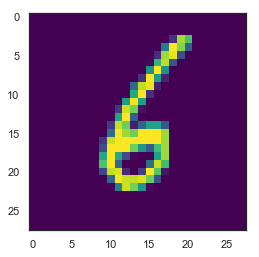

In [90]:
test_im = X_train[15]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [93]:
def info_layer(name_layer):
    layer_names = []
    for layer in model.layers:
        layer_names.append(layer.name) 
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        if layer_name.startswith(name_layer):
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]
            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))
            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0,:, :, col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image
            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

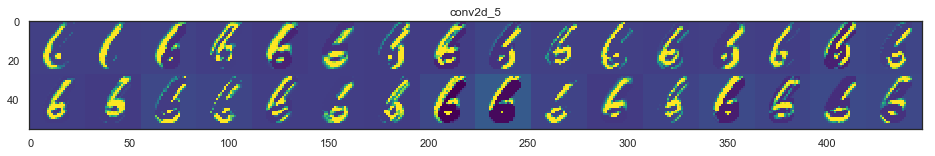

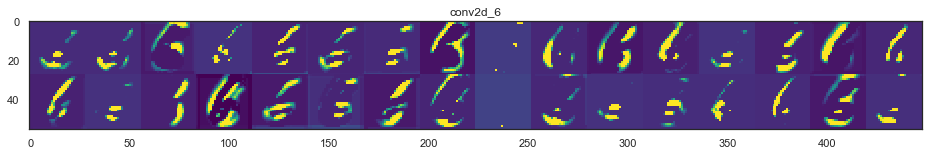

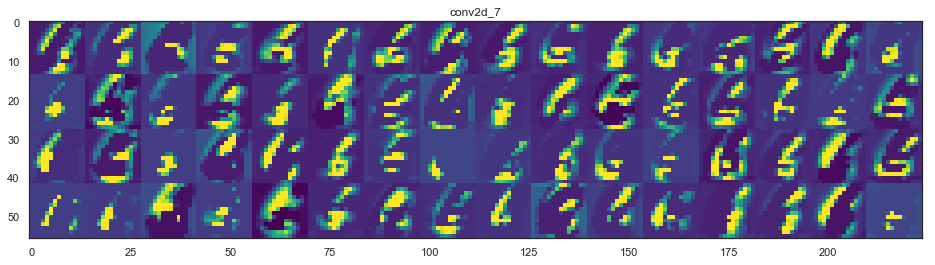

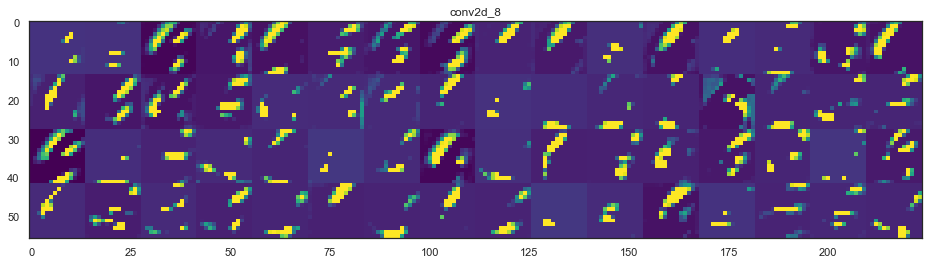

In [94]:
info_layer('conv')

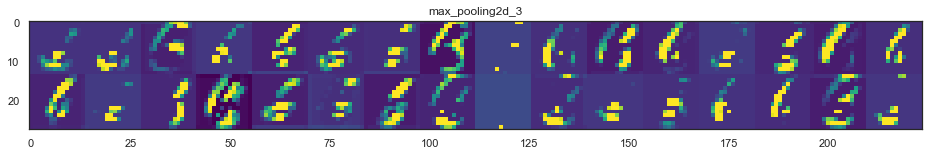

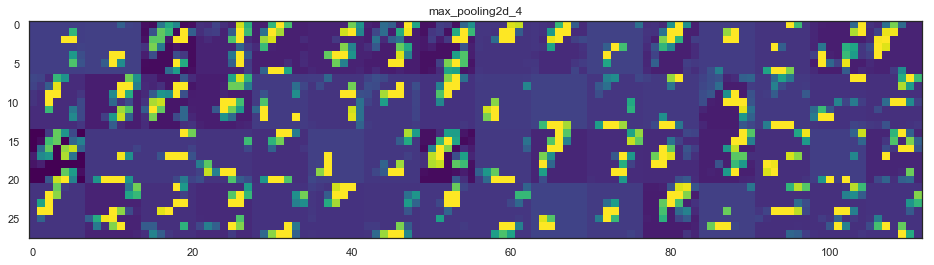

In [95]:
info_layer('max')

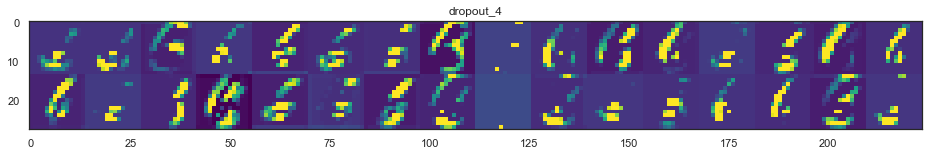

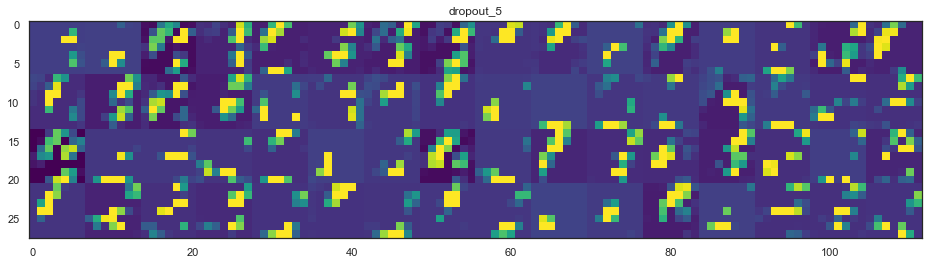

In [96]:
info_layer('drop')

Используемая литература:
  * https://en.wikipedia.org/wiki/Convolutional_neural_network
  * https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial
  * https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5